# IMPORT DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
import os
import rasterio as rio
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep
from tqdm import tqdm
import geopandas as gpd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,log_loss
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold
import math
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
samp = pd.read_csv(r'C:\Users\DELL\Desktop\Hackhathons\flood\SampleSubmission.csv')
df = pd.read_csv(r'C:\Users\DELL\Desktop\Hackhathons\flood\Train.csv')
pts = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.X, df.Y))
pts.to_file(r'C:\Users\DELL\Desktop\externaldata\points.shp')
# Load wetlands data
wetlands = gpd.read_file(r'C:\Users\DELL\Desktop\externaldata\wetlands\wetlands_100.shp')

In [3]:
malawi_TPI_data_path = os.path.join(r"C:\Users\DELL\Desktop\externaldata\TPI\TPI_malawi.tif")


with rio.open(malawi_TPI_data_path) as malawi_TPI_data:
    malawi_TPI_data_data = malawi_TPI_data.read(1, masked=True)
    malawi_TPI_data_meta = malawi_TPI_data.profile

In [4]:
malawi_TPI_data_meta

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 696, 'height': 924, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.008983152841195215, 0.0, 31.014245352698083,
       0.0, -0.008983152841195215, -9.059779134930608), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [5]:
# Extract zonal stats
TPI = rs.zonal_stats(pts,
                         malawi_TPI_data_data,
                         nodata=-999,
                         affine=malawi_TPI_data_meta['transform'],
                         geojson_out=True,
                         copy_properties=True,
                         stats='majority')
type(TPI)

list

## Comments: 
## Topographic position index greater than 0 is ridge
## Topographic position index less than 0 is valley
## Topographic position equal to 0 is flat

In [6]:
TPI_data = gpd.GeoDataFrame.from_features(TPI)
TPI_data.head(3)

,geometry,LC_Type1_mode,Square_ID,X,Y,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,...,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,target_2015,majority
0,POINT (34.26000 -15.91000),9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,887.764222,0.0,0.0,0.0,14.844025,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
1,POINT (34.26000 -15.90000),9,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,743.403912,0.0,0.0,0.0,14.844025,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0
2,POINT (34.26000 -15.89000),9,4e3c3898-14ce-11ea-bce5-f49634744a41,34.26,-15.89,565.728343,0.0,0.0,0.0,14.844025,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df["Typographic_position_index"] =TPI_data["majority"]

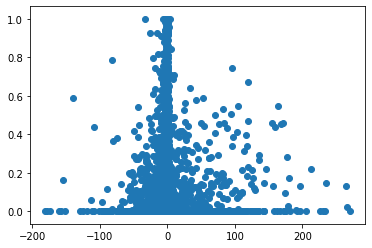

In [8]:
plt.scatter(TPI_data["majority"],TPI_data["target_2015"])

In [9]:
pts.shape

(16466, 42)

In [10]:
wetlands.head()

,fid,AREA_METER,PERIMETER_,MW_WETLAND,MW_WETLA_1,MW_WETLA_2,ACRES,HECTARES,geometry
0,1,2029147.125,10289.760,2.0,1.0,2.0,501.411,202.915,"POLYGON ((33.02261 -9.49706, 33.02220 -9.49698..."
1,2,1400282.125,5610.786,4.0,3.0,4.0,346.016,140.028,"POLYGON ((33.14564 -9.49550, 33.14519 -9.49544..."
2,3,1206303.875,8107.262,15.0,14.0,15.0,298.083,120.630,"POLYGON ((33.25196 -9.61700, 33.25134 -9.61693..."
3,4,1576612.500,9315.478,9.0,8.0,9.0,389.588,157.661,"POLYGON ((33.17747 -9.59722, 33.17708 -9.59662..."
4,5,1691864.125,8714.254,14.0,13.0,14.0,418.067,169.186,"POLYGON ((33.06316 -9.62432, 33.06232 -9.62420..."


Text(0.5, 0.98, 'WETLANDS')

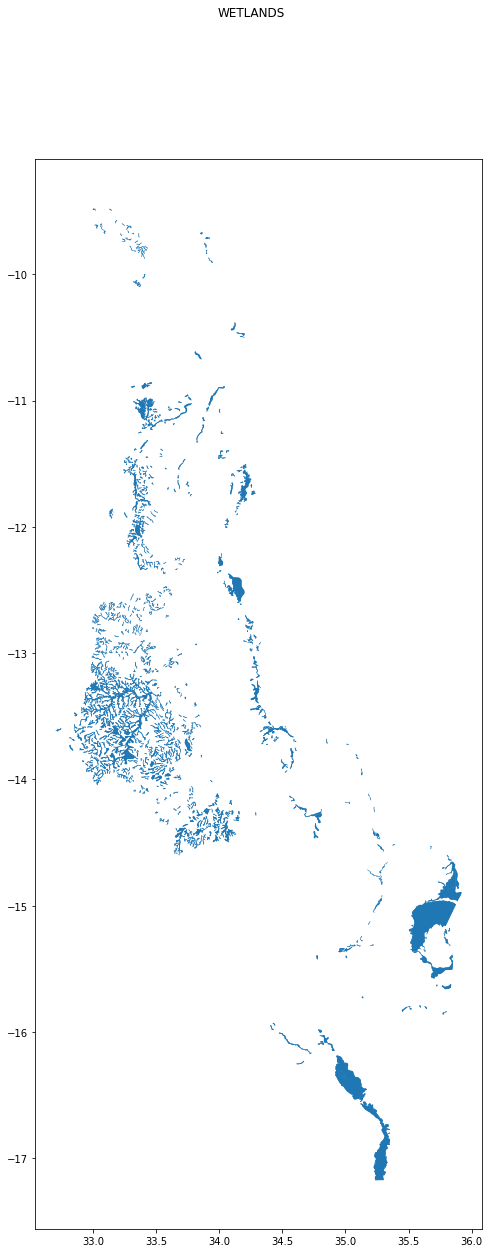

In [11]:
f, ax = plt.subplots(1, figsize=(8, 20))
ax = wetlands.plot(axes=ax,alpha=6)
f.suptitle('WETLANDS')

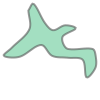

In [12]:
wetlands.loc[0, 'geometry']

In [13]:
# Print projection info
wetlands.crs

{'init': 'epsg:4326'}

In [14]:
# Set projection info for pts
pts.crs = 'epsg:4326'

In [15]:
wetlands.crs = {'init': 'epsg:4326'}

In [16]:
wetlands = wetlands.to_crs({'init': 'epsg:20935'})

In [17]:
pts_prj = pts.copy()

In [18]:
pts_prj.crs = {'init': 'epsg:4326'}

In [19]:
pts_prj = pts_prj.to_crs({'init': 'epsg:20935'})

In [20]:
# Calculate distance to wetland for each point
def min_distance(point, polygon):
    return polygon.distance(point).min()

pts_prj['wetland_distance'] = pts_prj.geometry.apply(min_distance, args=(wetlands, ))

In [21]:
len(pts_prj[pts_prj['wetland_distance'].isna()])

0

In [22]:
# Add to points data frame
pts['wetland_distance'] = pts_prj['wetland_distance']
pts.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,geometry,Typographic_position_index,wetland_distance
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.91000),57.0,15953.465740
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.90000),112.0,16265.216010
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.89000),0.0,16645.902409
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.88000),-4.0,17087.784546
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.87000),3.0,17589.245651


In [23]:
wetlanddistance = pts[['X','Y','elevation','wetland_distance']]

In [24]:
wetlanddistance.to_csv('wetlanddistance.csv', index=False)

In [25]:
malawi_srtm30meters_path = os.path.join(r"C:\Users\DELL\Desktop\externaldata\malawi_srtm30meters\malawi_srtm30meters.tif")

with rio.open(malawi_srtm30meters_path) as malawi_srtm30meters:
    malawi_srtm30meters_data = malawi_srtm30meters.read(1, masked=True)
    malawi_srtm30meters_meta = malawi_srtm30meters.profile

In [26]:
malawi_srtm30meters_meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 11672, 'height': 27964, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.00027777777777777734, 0.0, 32.67625,
       0.0, -0.0002777777777777772, -9.365138888888906), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

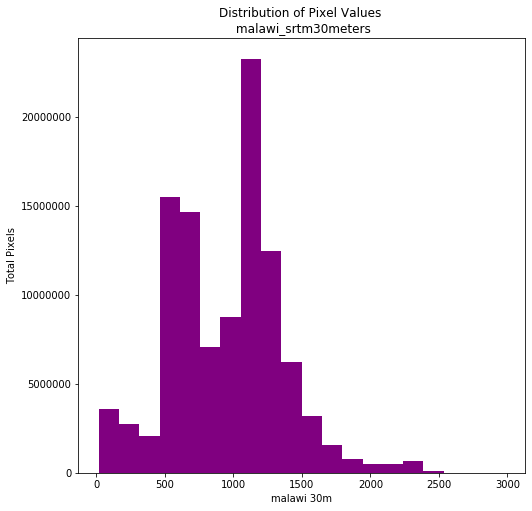

In [27]:
# Plotting a histogram with earthpy
ax=ep.hist(malawi_srtm30meters_data,
        figsize=(8,8),
        colors="purple",
        xlabel="malawi 30m",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n malawi_srtm30meters")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [28]:
# Extract strm stats
meters30_strm = rs.zonal_stats(pts,
                         malawi_srtm30meters_data,
                         nodata=-999,
                         affine=malawi_srtm30meters_meta['transform'],
                         geojson_out=True,
                         copy_properties=True,
                         stats='majority')

# View object type
type(meters30_strm)

list

In [29]:
# Turn extracted data into a pandas geodataframe
meters30_df = gpd.GeoDataFrame.from_features(meters30_strm)
meters30_df.head(2)

,geometry,LC_Type1_mode,Square_ID,Typographic_position_index,X,Y,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,...,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,target_2015,wetland_distance,majority
0,POINT (34.26000 -15.91000),9,4e3c3896-14ce-11ea-bce5-f49634744a41,57.0,34.26,-15.91,887.764222,0.0,0.0,0.0,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15953.46574,-32768.0
1,POINT (34.26000 -15.90000),9,4e3c3897-14ce-11ea-bce5-f49634744a41,112.0,34.26,-15.90,743.403912,0.0,0.0,0.0,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16265.21601,742.0


In [30]:
meters30_df.to_csv('newdata1.csv', index=False)

In [31]:
# find if there are rows with no data
len(meters30_df[meters30_df['majority'].isna()])

0

In [32]:
len(meters30_df[meters30_df['majority'] > 0])

16265

In [33]:
# Replace negative values with 0
meters30_df['majority'][meters30_df['majority'] < 0] = 0

In [34]:
len(meters30_df[meters30_df['majority'] < 0])

0

In [35]:
meters30_df.shape

(16466, 44)

In [36]:
# Join with points dataset
pts['malawi_srtm30meters'] = meters30_df.majority
pts.shape

(16466, 44)

In [37]:
pts.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,geometry,Typographic_position_index,wetland_distance,malawi_srtm30meters
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.91000),57.0,15953.465740,0.0
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.90000),112.0,16265.216010,742.0
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.89000),0.0,16645.902409,607.0
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.88000),-4.0,17087.784546,436.0
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.87000),3.0,17589.245651,486.0


In [38]:
pts.to_csv('newdata2.csv', index=False)

In [39]:
malawi_poverty_level_path = os.path.join(r"C:\Users\DELL\Desktop\externaldata\malawi_national_poverty_levels0\malawi_national_poverty_levels0.tif")

with rio.open(malawi_poverty_level_path) as malawi_poverty_level:
    malawi_poverty_level_data = malawi_poverty_level.read(1, masked=True)
    malawi_poverty_level_meta = malawi_poverty_level.profile

In [40]:
malawi_poverty_level_meta

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -1.797693e+308, 'width': 325, 'height': 776, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.01, 0.0, 32.67668701171875,
       0.0, -0.01, -9.364999999999997), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

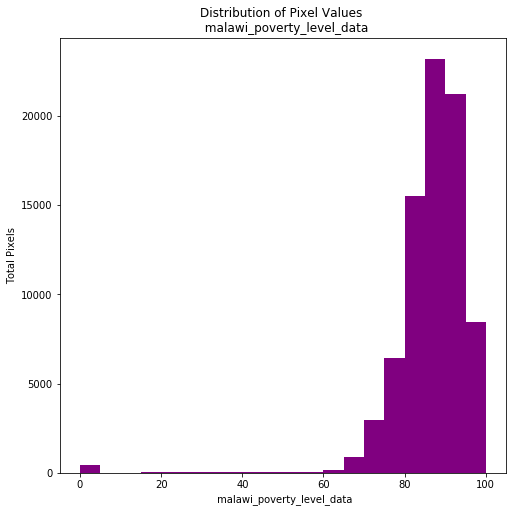

In [41]:
# Plotting a histogram with earthpy
ax=ep.hist( malawi_poverty_level_data,
        figsize=(8,8),
        colors="purple",
        xlabel=" malawi_poverty_level_data",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n  malawi_poverty_level_data")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [42]:
# Extract strm stats
malawi_poverty= rs.zonal_stats(pts,
                         malawi_poverty_level_data,
                         nodata=-999,
                         affine=malawi_poverty_level_meta['transform'],
                         geojson_out=True,
                         copy_properties=True,
                         stats='majority')

# View object type
type(malawi_poverty)

list

In [43]:
# Turn extracted data into a pandas geodataframe
malawi_poverty_df = gpd.GeoDataFrame.from_features(malawi_poverty)
malawi_poverty_df.head(2)

,geometry,LC_Type1_mode,Square_ID,Typographic_position_index,X,Y,elevation,malawi_srtm30meters,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,...,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,target_2015,wetland_distance,majority
0,POINT (34.26000 -15.91000),9,4e3c3896-14ce-11ea-bce5-f49634744a41,57.0,34.26,-15.91,887.764222,0.0,0.0,0.0,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15953.46574,95.388485
1,POINT (34.26000 -15.90000),9,4e3c3897-14ce-11ea-bce5-f49634744a41,112.0,34.26,-15.90,743.403912,742.0,0.0,0.0,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16265.21601,95.521016


In [44]:
malawi_poverty_df.to_csv('newdata3.csv', index=False)

In [45]:
# find if there are rows with no data
len(malawi_poverty_df[malawi_poverty_df['majority'].isna()])

0

In [46]:
# Replace negative values with 0
malawi_poverty_df['majority'][malawi_poverty_df['majority'] < 0] = 0

In [47]:
# Join with points dataset
pts['malawi_poverty_level'] =malawi_poverty_df.majority

In [48]:
pts.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,geometry,Typographic_position_index,wetland_distance,malawi_srtm30meters,malawi_poverty_level
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.91000),57.0,15953.465740,0.0,95.388485
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.90000),112.0,16265.216010,742.0,95.521016
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.89000),0.0,16645.902409,607.0,95.733085
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.88000),-4.0,17087.784546,436.0,96.254659
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.87000),3.0,17589.245651,486.0,95.665613


In [49]:
pts.to_csv('externaldata.csv', index=False)

# QUERY STARTS

In [50]:
samp = pd.read_csv(r'C:\Users\DELL\Desktop\Hackhathons\flood\SampleSubmission.csv')
df = pd.read_csv(r'C:\Users\DELL\Desktop\zindi\\externaldata.csv')

In [51]:
df.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,geometry,Typographic_position_index,wetland_distance,malawi_srtm30meters,malawi_poverty_level
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.91),57.0,15953.465740,0.0,95.388485
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.9),112.0,16265.216010,742.0,95.521016
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.89),0.0,16645.902409,607.0,95.733085
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.88),-4.0,17087.784546,436.0,96.254659
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,POINT (34.26 -15.87),3.0,17589.245651,486.0,95.665613


In [52]:
# Creating lists of columns to be used in separating the dataframe into training and testing datasets
# Using a for loop for efficiency
precip_features_2019 = []
precip_features_2015 = []
for col in df.columns:
  if '2019' in col:
    precip_features_2019.append(col)
  elif 'precip 2014' in col:
    precip_features_2015.append(col)
  elif 'precip 2015' in col:
    precip_features_2015.append(col)

In [53]:
 #Separating the train dataset from the main dataframe
train = df[df.columns.difference(precip_features_2019)]
train.head(2)

,LC_Type1_mode,Square_ID,Typographic_position_index,X,Y,elevation,geometry,malawi_poverty_level,malawi_srtm30meters,precip 2014-11-16 - 2014-11-23,...,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,target_2015,wetland_distance
0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,57.0,34.26,-15.91,887.764222,POINT (34.26 -15.91),95.388485,0.0,0.0,...,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,0.0,15953.46574
1,9,4e3c3897-14ce-11ea-bce5-f49634744a41,112.0,34.26,-15.90,743.403912,POINT (34.26 -15.9),95.521016,742.0,0.0,...,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,0.0,16265.21601


In [54]:
train.columns

Index(['LC_Type1_mode', 'Square_ID', 'Typographic_position_index', 'X', 'Y',
       'elevation', 'geometry', 'malawi_poverty_level', 'malawi_srtm30meters',
       'precip 2014-11-16 - 2014-11-23', 'precip 2014-11-23 - 2014-11-30',
       'precip 2014-11-30 - 2014-12-07', 'precip 2014-12-07 - 2014-12-14',
       'precip 2014-12-14 - 2014-12-21', 'precip 2014-12-21 - 2014-12-28',
       'precip 2014-12-28 - 2015-01-04', 'precip 2015-01-04 - 2015-01-11',
       'precip 2015-01-11 - 2015-01-18', 'precip 2015-01-18 - 2015-01-25',
       'precip 2015-01-25 - 2015-02-01', 'precip 2015-02-01 - 2015-02-08',
       'precip 2015-02-08 - 2015-02-15', 'precip 2015-02-15 - 2015-02-22',
       'precip 2015-02-22 - 2015-03-01', 'precip 2015-03-01 - 2015-03-08',
       'precip 2015-03-08 - 2015-03-15', 'target_2015', 'wetland_distance'],
      dtype='object')

In [55]:
# Separating the test dataset from the main dataframe
precip_features_2019.extend(['X','Y','elevation', 'Typographic_position_index','LC_Type1_mode','Square_ID','wetland_distance'])
test = df[precip_features_2019]
test.head(2)

,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,...,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,X,Y,elevation,Typographic_position_index,LC_Type1_mode,Square_ID,wetland_distance
0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,34.26,-15.91,887.764222,57.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.46574
1,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,34.26,-15.90,743.403912,112.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.21601


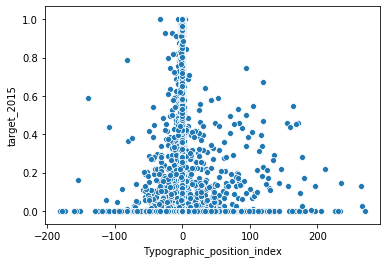

In [56]:
sns.scatterplot(x ='Typographic_position_index', y ='target_2015', data =train)

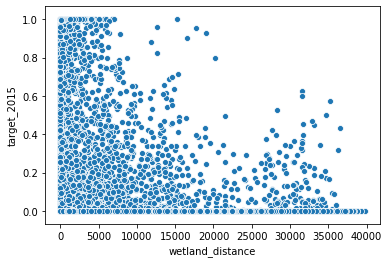

In [57]:
sns.scatterplot(x ='wetland_distance', y ='target_2015', data =train)

In [58]:
# Creating a dictionary of column names to be renamed for the training dataset
# The column names are renamed for conveniency
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):
  if 'precip' in col:
    new_2015_cols[col] = 'week_' + str(number) + '_precip'

    
# Creating a dictionary of column names to be renamed for the testing dataset
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
  if 'precip' in col:
    new_2019_cols[col] = 'week_' + str(number) + '_precip'
    
# Renaming the columns
train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)

In [59]:
test.columns

Index(['week_1_precip', 'week_2_precip', 'week_3_precip', 'week_4_precip',
       'week_5_precip', 'week_6_precip', 'week_7_precip', 'week_8_precip',
       'week_9_precip', 'week_10_precip', 'week_11_precip', 'week_12_precip',
       'week_13_precip', 'week_14_precip', 'week_15_precip', 'week_16_precip',
       'week_17_precip', 'X', 'Y', 'elevation', 'Typographic_position_index',
       'LC_Type1_mode', 'Square_ID', 'wetland_distance'],
      dtype='object')

In [60]:
train.columns

Index(['LC_Type1_mode', 'Square_ID', 'Typographic_position_index', 'X', 'Y',
       'elevation', 'geometry', 'malawi_poverty_level', 'malawi_srtm30meters',
       'week_1_precip', 'week_2_precip', 'week_3_precip', 'week_4_precip',
       'week_5_precip', 'week_6_precip', 'week_7_precip', 'week_8_precip',
       'week_9_precip', 'week_10_precip', 'week_11_precip', 'week_12_precip',
       'week_13_precip', 'week_14_precip', 'week_15_precip', 'week_16_precip',
       'week_17_precip', 'target_2015', 'wetland_distance'],
      dtype='object')

In [61]:
train=train[['week_1_precip', 'week_2_precip', 'week_3_precip', 'week_4_precip',
       'week_5_precip', 'week_6_precip', 'week_7_precip', 'week_8_precip',
       'week_9_precip', 'week_10_precip', 'week_11_precip', 'week_12_precip',
       'week_13_precip', 'week_14_precip', 'week_15_precip', 'week_16_precip',
       'week_17_precip', 'X', 'Y', 'elevation', 'Typographic_position_index',
       'LC_Type1_mode', 'Square_ID', 'wetland_distance','target_2015']]

In [62]:
print(train.shape, test.shape)

(16466, 25) (16466, 24)


# OUTLIERS DETECTION

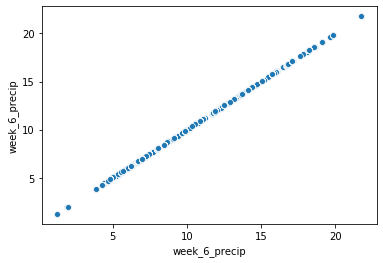

In [63]:
sns.scatterplot(x='week_6_precip', y='week_6_precip', data=train)

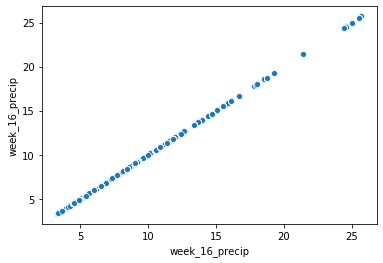

In [64]:
sns.scatterplot(x='week_16_precip', y='week_16_precip', data=train)

In [65]:
wk6 = train[train['week_6_precip'] > 21].index
wk13 = train[train['week_13_precip'] > 25].index
wk14 = train[train['week_14_precip'] > 14].index
wk15 = train[train['week_15_precip'] > 32].index
wk16 = train[train['week_16_precip'] > 20].index
wk10 = train[train['week_10_precip'] > 9].index

In [66]:
# Drop those rows from the training data.
train.drop(wk6, axis=0, inplace=True)
train.drop(wk13, axis=0, inplace=True)
train.drop(wk14, axis=0, inplace=True)
train.drop(wk15, axis=0, inplace=True)
train.drop(wk10, axis=0, inplace=True)

In [67]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['week_1_precip',
 'week_2_precip',
 'week_3_precip',
 'week_4_precip',
 'week_5_precip',
 'week_6_precip',
 'week_7_precip',
 'week_8_precip',
 'week_9_precip',
 'week_10_precip',
 'week_11_precip',
 'week_12_precip',
 'week_13_precip',
 'week_14_precip',
 'week_15_precip',
 'week_16_precip',
 'week_17_precip',
 'X',
 'Y',
 'elevation',
 'Typographic_position_index',
 'LC_Type1_mode',
 'Square_ID',
 'wetland_distance',
 'target_2015']

In [68]:
#Manual computation of chikawa and nsaje (latitude and longitude) areas near to the lake
data['chikawa_X'] =34.7741
data['chikawa_Y'] =-16.1958
data['nsaje_X'] =35.2533
data['nsaje_Y'] =-16.9206

In [69]:
data.head()

,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,...,elevation,Typographic_position_index,LC_Type1_mode,Square_ID,wetland_distance,target_2015,chikawa_X,chikawa_Y,nsaje_X,nsaje_Y
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,887.764222,57.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,0.0,34.7741,-16.1958,35.2533,-16.9206
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,743.403912,112.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,0.0,34.7741,-16.1958,35.2533,-16.9206
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,565.728343,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,0.0,34.7741,-16.1958,35.2533,-16.9206
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,443.392774,-4.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,0.0,34.7741,-16.1958,35.2533,-16.9206
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,437.443428,3.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,0.0,34.7741,-16.1958,35.2533,-16.9206


In [70]:
from geopy.distance import vincenty

In [71]:
def distance_calc (row):
    start = (row['nsaje_X'], row['nsaje_Y'])
    stop = (row['X'], row['Y'])

    return vincenty(start, stop).meters

In [72]:
def distance_calc2(row):
    start = (row['chikawa_X'], row['chikawa_X'])
    stop = (row['X'], row['Y'])

    return vincenty(start, stop).meters

In [73]:
data['from_chikawa_to_axis'] = data.apply (lambda row: distance_calc2(row),axis=1)

In [74]:
data['from_nsaje_to_axis'] = data.apply (lambda row: distance_calc (row),axis=1)

In [75]:
data.head()

,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,...,LC_Type1_mode,Square_ID,wetland_distance,target_2015,chikawa_X,chikawa_Y,nsaje_X,nsaje_Y,from_chikawa_to_axis,from_nsaje_to_axis
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602924e+06,143886.494791
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602037e+06,144476.923418
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,0.0,34.7741,-16.1958,35.2533,-16.9206,4.601150e+06,145070.726844
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,0.0,34.7741,-16.1958,35.2533,-16.9206,4.600264e+06,145667.863794
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,0.0,34.7741,-16.1958,35.2533,-16.9206,4.599377e+06,146268.293433


In [77]:
data.head()

,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,...,LC_Type1_mode,Square_ID,wetland_distance,target_2015,chikawa_X,chikawa_Y,nsaje_X,nsaje_Y,from_chikawa_to_axis,from_nsaje_to_axis
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3896-14ce-11ea-bce5-f49634744a41,15953.465740,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602924e+06,143886.494791
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3897-14ce-11ea-bce5-f49634744a41,16265.216010,0.0,34.7741,-16.1958,35.2533,-16.9206,4.602037e+06,144476.923418
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,9,4e3c3898-14ce-11ea-bce5-f49634744a41,16645.902409,0.0,34.7741,-16.1958,35.2533,-16.9206,4.601150e+06,145070.726844
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c3899-14ce-11ea-bce5-f49634744a41,17087.784546,0.0,34.7741,-16.1958,35.2533,-16.9206,4.600264e+06,145667.863794
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,...,10,4e3c389a-14ce-11ea-bce5-f49634744a41,17589.245651,0.0,34.7741,-16.1958,35.2533,-16.9206,4.599377e+06,146268.293433


In [78]:
features=features=[ 'week_1_precip','week_2_precip','week_3_precip', 'week_4_precip', 'week_5_precip',
          'week_6_precip', 'week_7_precip', 'week_8_precip', 'week_9_precip',
          'week_10_precip', 'week_11_precip', 'week_12_precip', 'week_13_precip',
          'week_14_precip', 'week_15_precip', 'week_16_precip', 'week_17_precip','Typographic_position_index'
         ]

In [79]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["median_"+col_name]=x[col_name].apply(np.median)
    return x  

In [80]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:04<00:00,  3.58s/it]


In [81]:
train=data[data.target_2015.notnull()].reset_index(drop=True)
test=data[data.target_2015.isna()].reset_index(drop=True)

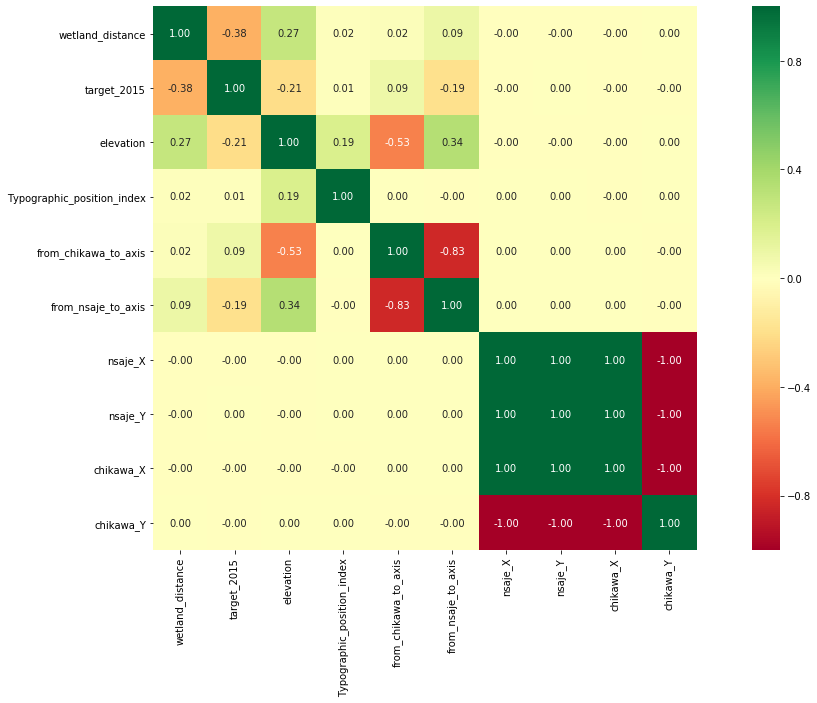

In [82]:
#correlelogram- plot heatmap to find correlation among features
corrmat =train.corr()
f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train[['wetland_distance','target_2015','elevation','Typographic_position_index','from_chikawa_to_axis','from_nsaje_to_axis','nsaje_X','nsaje_Y','chikawa_X','chikawa_Y']].corr(), square=True, cmap=plt.cm.RdYlGn, annot=True, fmt=".2f")
#wk1, wk2, wk3 -same multicollinearity

In [83]:
test=test.drop(['chikawa_X','chikawa_Y','nsaje_X','nsaje_Y'], axis=1)
train=train.drop(['chikawa_X','chikawa_Y','nsaje_X','nsaje_Y'], axis=1)

In [84]:
test_id = test['Square_ID']

In [85]:
train = train.drop(['Square_ID'], axis=1)

In [86]:
test = test.drop(['Square_ID'], axis=1)

In [87]:
test = test.drop('target_2015', axis=1)

In [88]:
def threshold(x):
    if x >= 0.40:
        return 1
    else:
        return 0
train['target_2015'] = train['target_2015'].apply(threshold)

In [89]:
X = train.drop(['target_2015'], axis=1)
y = train['target_2015']

In [90]:

X_fold, X_val, y_fold, y_val = train_test_split(X, y, test_size=0.25, random_state=1913)

In [91]:

param = { 
         'objective':'binary','sub_sample':0.9,
         'max_depth': -1,
         'learning_rate': 0.028,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "metric": 'auc',
        'seed':1899,
         "verbose": -0}

In [92]:

errcb=[]
y_pred_totcb=[]
fold=RepeatedStratifiedKFold(n_splits=4, random_state=1992, n_repeats=4)

for train_index, test_index in fold.split(X_fold,y_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=LGBMClassifier(**param)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train)],verbose=100, early_stopping_rounds=300)
    preds=m.predict_proba(X_test)
    print("err: ",log_loss(y_test,preds))
    errcb.append(log_loss(y_test,preds))
    p = m.predict_proba(test)[:,1]
    y_pred_totcb.append(p)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.997729
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.997729
err:  0.06253673585064151
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.997715
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.997715
err:  0.0643286109654622
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.997513
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.997513
err:  0.06782778661781924
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.997411
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.997411
err:  0.06488736238461043
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.997746
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.997746
err:  0.0632516403079379
Training unt

In [93]:
np.mean(errcb)

0.06486942937477216

# FEATURE IMPORTANCE

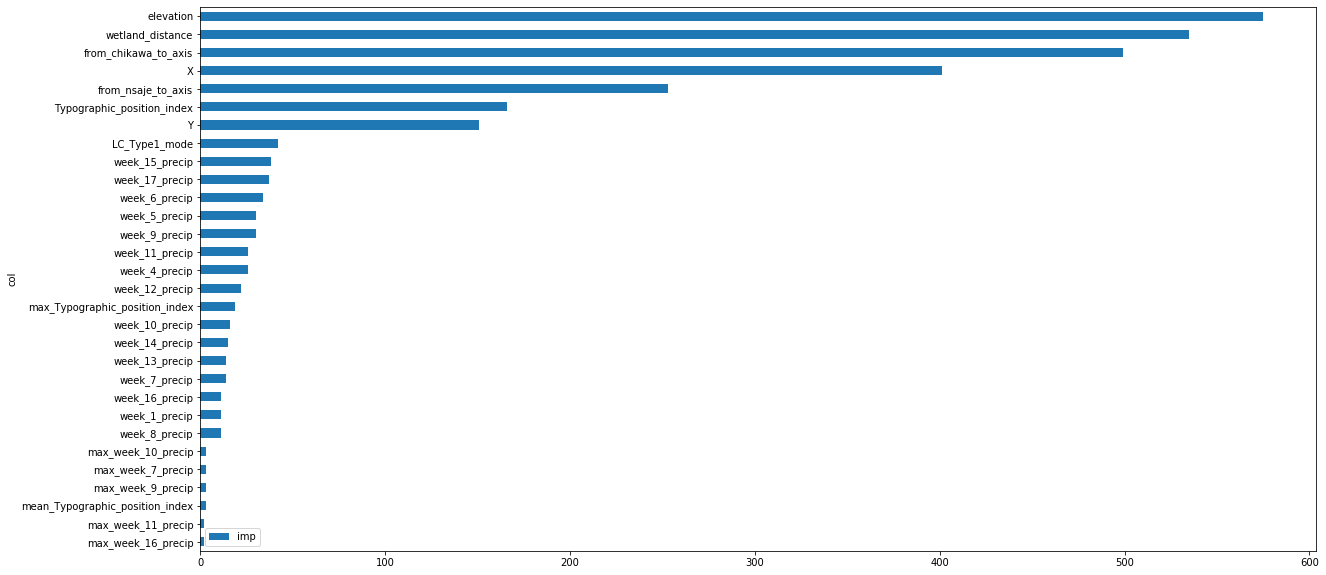

In [94]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [95]:
d = {"Square_ID": samp['Square_ID'], 'target_2015':np.mean(y_pred_totcb,0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Square_ID", 'target_2015']]

In [96]:
test_predictions.head()

,Square_ID,target_2015
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.007417
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.007723
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.008884
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.005711
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.005732


In [97]:
test_predictions.to_csv('MODELF.csv', index=False)